# A notebook for exploring how best to measure the change in Mtb

In [610]:
import napari
from macrohet import dataio, tile, tools, visualise
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage import io, transform

### Load all metadata

Both the image metadata and the assay layout metadata

In [4]:
%%time
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
CPU times: user 18.4 s, sys: 1.45 s, total: 19.9 s
Wall time: 19.8 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [303]:
%%time
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!
CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 21 ms


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [6]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/07/14 01:43:20 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/07/14 01:43:20 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/07/14 01:43:20 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/07/14 01:43:20 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/07/14 01:43:20 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/07/14 01:43:21 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/07/14 01:43:21 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/07/14 01:43:21 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/07/14 01:43:38 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/07/14 01:43:38 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/07/14 01:43:38 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:38 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:38 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/07/14 01:43:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/07/14 01:43:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/07/14 01:43:39 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:39 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:39 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/07/14 01:43:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/07/14 01:43:39 PM] Opening HDF file: /mnt/DATA/macrohe

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [7]:
%%time

df = pd.read_pickle(os.path.join(base_dir,'results/preliminary_sc_measures/sc_dfs/sc_df_40_interp.pkl'))
df

CPU times: user 135 ms, sys: 109 ms, total: 243 ms
Wall time: 251 ms


,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019


### Renaming delta Mtb method of choice for ease of use

In [8]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

# Style

In [623]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [10]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [11]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

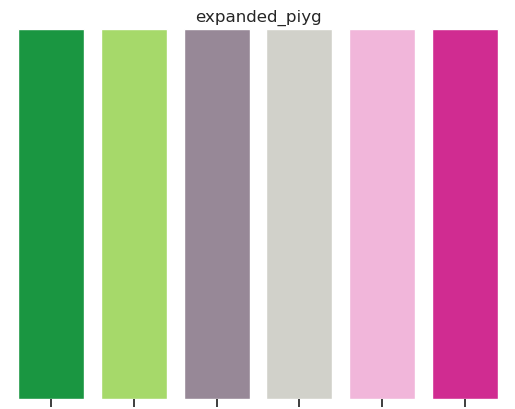

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [621]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [13]:
output_dir = os.path.join(base_dir, 'results/preliminary_sc_measures/sc_graphs/dmtb_all_conditions')
os.makedirs(output_dir, exist_ok = True)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [611]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb,Compound/Strain
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232,RD1
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,1.0,-0.000112,RD1
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,1.0,0.000000,RD1
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,1.0,0.000586,RD1
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,1.0,0.000544,RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,2.0,0.000032,BDQ
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,2.0,-0.000153,BDQ
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,2.0,0.000089,BDQ
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,2.0,0.000167,BDQ


In [320]:
df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'})


,Strain,Compound,Concentration,count
0,RD1,CTRL,EC0,1344
1,WT,BDQ,EC50,908
2,WT,BDQ,EC99,684
3,WT,CTRL,EC0,1934
4,WT,INH,EC50,842
5,WT,INH,EC99,817
6,WT,PZA,EC50,918
7,WT,PZA,EC99,901
8,WT,RIF,EC50,817
9,WT,RIF,EC99,863


In [612]:
for index, row_ in df_delta_mtb.iterrows():
    cell_ID = row_['Cell ID']
    row, column = row_['Acquisition ID']
    online_fn = f'https://macrohet.s3.eu-west-2.amazonaws.com/{row},{column}/glimpse_{cell_ID}.{row}.{column}_t0.png'
    df_delta_mtb.at[index, 'glimpse_url'] = online_fn
    t0 = row_['Time (hours)']
    df_delta_mtb.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
    df_delta_mtb.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

# Creating static plot showing dMtb across one condition

In [613]:
# Assuming your DataFrame is named 'df'
df_delta_mtb['Strain/Compound'] = df_delta_mtb['Compound']  # Create a new column and copy values from 'Compound'

# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df_delta_mtb.loc[df_delta_mtb['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'


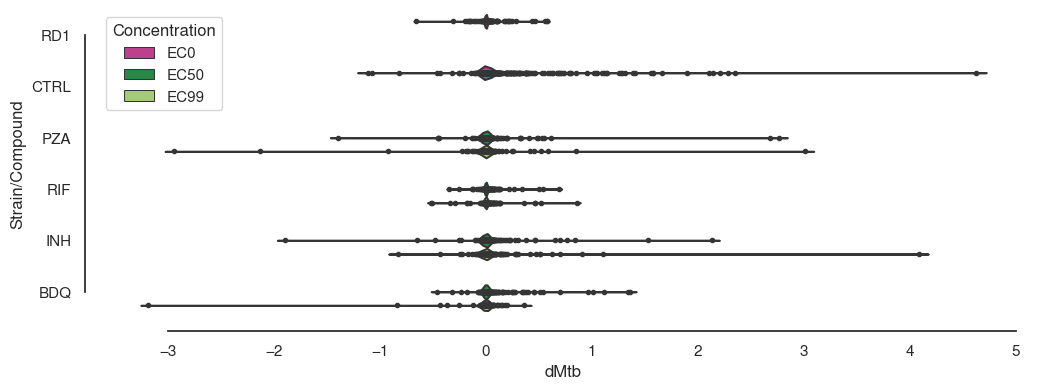

In [162]:
plt.figure(figsize=(12, 4))

sns.violinplot(x="dMtb", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df_delta_mtb, 
            fliersize=15, 
#             scale = 'width', 
            inner = 'point', 
#             width=1.1
#             scale = 'area', scale_hue=True
#             gridsize = 10
              )
# plt.xlim(-1, 5)


sns.despine(offset=10, trim=True)

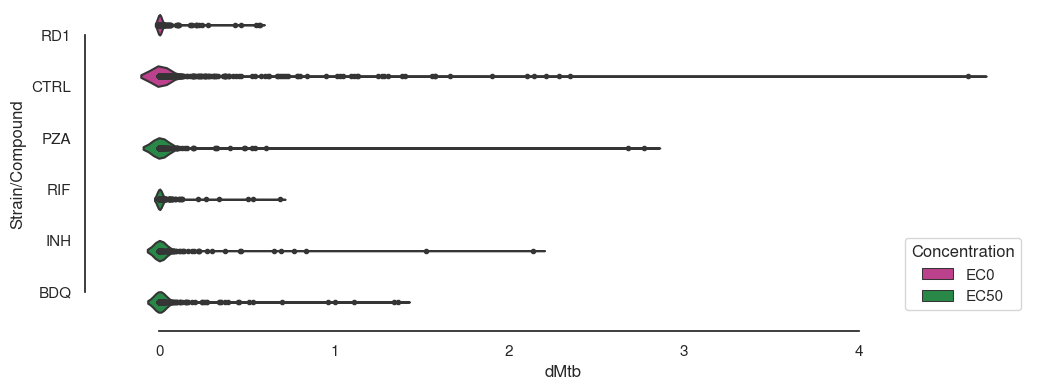

In [154]:
plt.figure(figsize=(12, 4))

sns.violinplot(x="dMtb", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df_delta_mtb[(df_delta_mtb['Concentration'] != 'EC99') & (df_delta_mtb['dMtb'] >0)], 
            fliersize=15, 
#             scale = 'width', 
            inner = 'point', 
#             width=1.1
#             scale = 'area', scale_hue=True
#             gridsize = 10
              )
# plt.xlim(-1, 5)


sns.despine(offset=10, trim=True)

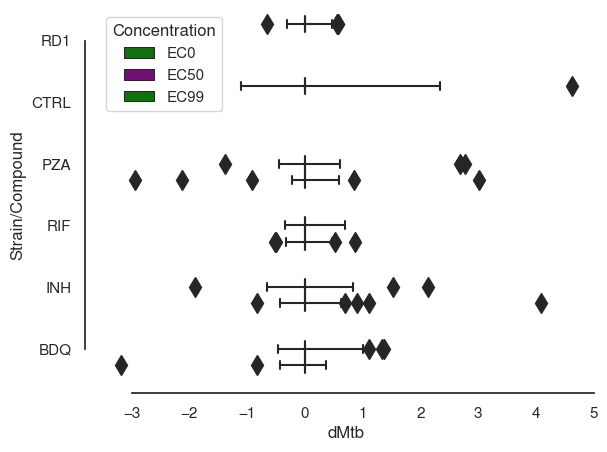

In [79]:
sns.boxplot(x="dMtb", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[2]],
            data=df_delta_mtb, 
            fliersize=10, whis = 2000) #  whis is 2000 times the interquartile range here!

sns.despine(offset=10, trim=True)

# Just plot KDE, then cropped, then highlight, then etc etc

In [617]:
df_delta_mtb = df_delta_mtb.drop(41983) # drop the original control (false track)
df_delta_mtb = df_delta_mtb.drop(613711) # drop the original pza (false track)

In [618]:
# Find the maximum value of df_delta_mtb['dMtb'] for each unique value of df_delta_mtb['Compound/Strain']
max_values = df_delta_mtb.groupby('Compound/Strain')['dMtb'].transform('max')

# Create a new DataFrame with only the rows that contain the maximum values
df_max_dmtb = df_delta_mtb[df_delta_mtb['dMtb'] == max_values]


In [619]:
df_max_dmtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb,Compound/Strain,glimpse_url,glimpse_url_t0,glimpse_url_tn,Strain/Compound
36197,0,933.322388,697.360840,4703.944834,3514.698633,0.0,0.0,1.0,18897.0,377.389099,...,106,"(3, 5)",106.3.5,1.0,2.346850,CTRL,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,CTRL
69880,0,883.031555,1056.135254,4450.479038,5322.921680,1.0,1.0,1.0,12569.0,377.961823,...,299,"(3, 6)",299.3.6,1.0,2.769864,PZA,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,PZA
357011,3,120.883926,481.851959,609.254989,2428.533875,0.0,0.0,1.0,14986.0,368.642548,...,912,"(4, 9)",912.4.9,2.0,1.364311,BDQ,"https://macrohet.s3.eu-west-2.amazonaws.com/4,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,BDQ
533683,0,993.871277,588.351807,5009.111235,2965.293105,1.0,1.0,1.0,15924.0,413.437317,...,592,"(6, 4)",592.6.4,4.0,0.577751,RD1,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,RD1
621101,0,1162.731201,259.177124,5860.165254,1306.252705,1.0,1.0,1.0,14046.0,364.640167,...,399,"(6, 7)",399.6.7,2.0,0.862044,RIF,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,RIF
657222,0,388.780487,668.168152,1959.453655,3367.567485,0.0,0.0,1.0,23630.0,363.540588,...,96,"(6, 8)",96.6.8,2.0,4.088434,INH,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,INH


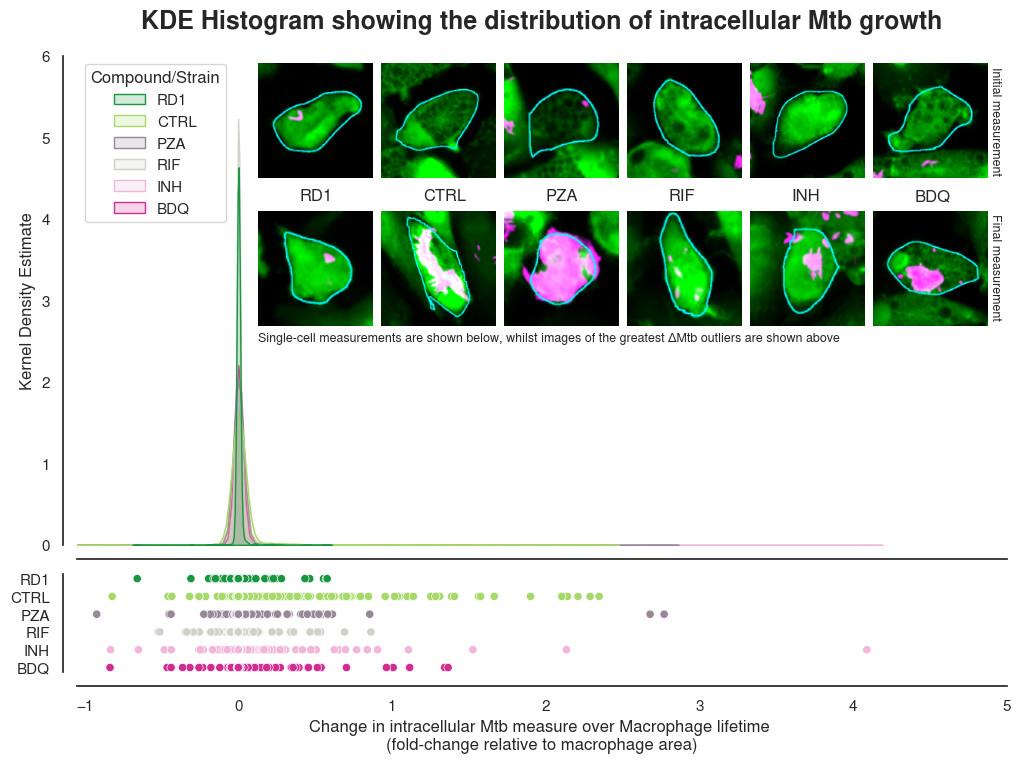

In [628]:
sns.set(font='Nimbus Sans', style = 'white')
sns.set_palette(expanded_piyg)

# Set the desired figure size and height ratios
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12,8), gridspec_kw={'height_ratios': [5, 1]})
plt.rc('legend', loc="upper left", )

# Plot the KDE plot on ax1
kde_plot = sns.kdeplot(data=df_delta_mtb, x='dMtb', hue='Compound/Strain', ax=ax1, linewidth = 1, alpha = 0.2, fill = True
                      )

# Plot the scatter plot on ax2
scatter_plot = sns.scatterplot(data=df_delta_mtb, x='dMtb', y='Compound/Strain', hue='Compound/Strain', ax=ax2, legend=False)

# Remove y-axis labels for ax2
ax2.set_ylabel('')
# Remove y-axis labels for ax1
ax1.set_ylabel('Kernel Density Estimate')

# Set x-axis limits
ax1.set_xlim(-1.05, 5)
ax1.set_ylim(0,6)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.1)

# iterate over 6 of the top outliers
# for n, (i, row_) in enumerate(df_max_dmtb.iterrows()):
## this way iterates over in the same order as the y axis
for n, sc in enumerate(reversed(df_delta_mtb['Strain/Compound'].unique().tolist())):
    # extract 
    row_ = df_max_dmtb[df_max_dmtb['Strain/Compound'] == sc]
    # load both images into memory
    img_t0 = io.imread(row_['glimpse_url_t0'].iloc[0])
    img_tn = io.imread(row_['glimpse_url_tn'].iloc[0])
    # Resize the images to 100x100 pixels
    img_t0 = transform.resize(img_t0, (150, 150), anti_aliasing=True)
    img_tn = transform.resize(img_tn, (150, 150), anti_aliasing=True)
    # add images
    imagebox = OffsetImage(img_t0, zoom = 0.55)
    # add coords for t0 images
    x = len(df_max_dmtb)-(n*0.8)-1.5
    y = 5.2
    coords = x, y
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False)
    ax1.add_artist(ab)
    imagebox = OffsetImage(img_tn, zoom = 0.55)
    # add coords for tn images
    y = y - 1.81
    coords = x, y
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False)
    ax1.add_artist(ab)
    # add labels
    ax1.text(x = coords[0]-0.1, y = y+0.84, s = row_['Compound/Strain'].iloc[0])
    
ax1.text(x =4.88, y = 4.57, s = 'Initial measurement', rotation = -90, fontsize = 9)
ax1.text(x =4.88, y = 2.8, s = 'Final measurement', rotation = -90, fontsize = 9)

ax1.text(x=0.13, y=2.5, s='Single-cell measurements are shown below, whilst images of the greatest ΔMtb outliers are shown above', 
        fontsize=9)

ax2.set_xlabel('Change in intracellular Mtb measure over Macrophage lifetime \n(fold-change relative to macrophage area)')
# Remove spines and trim
sns.despine(offset=10, )
# set title
title_text = 'KDE Histogram showing the distribution of intracellular Mtb growth'
title = ax1.set_title(title_text, y=1.04)
# title.set_text(title_text)
title.set_fontsize(18)
title.set_fontweight('heavy')
#save fig
plt.savefig(os.path.join(output_dir, 'KDE_dMtb_sc_eg.png'), dpi = 314, bbox_inches = 'tight')
# Display the plot
plt.show()

In [626]:
output_dir

'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/dmtb_all_conditions'

# Change the shape 

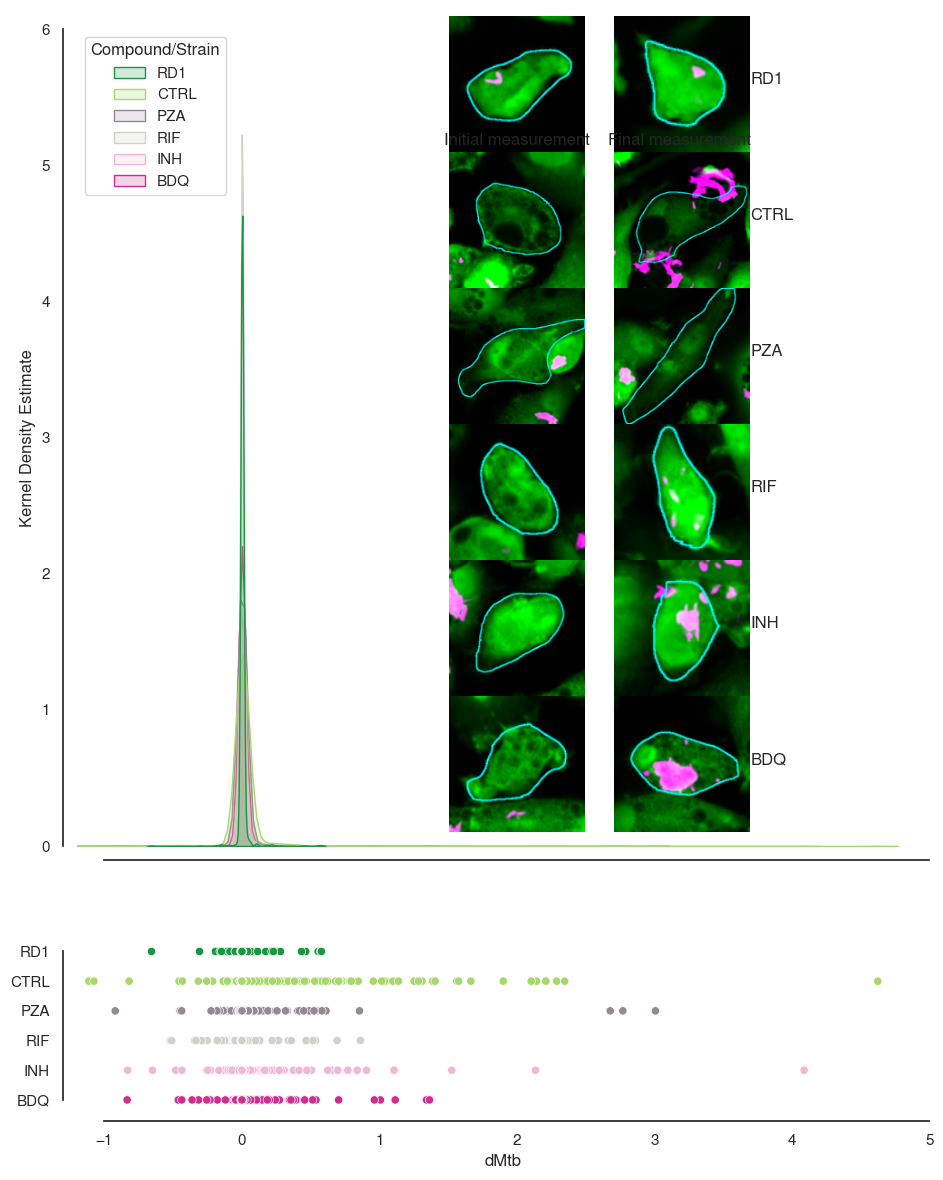

In [450]:
# Set the desired figure size and height ratios
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11,14), gridspec_kw={'height_ratios': [5, 1]})
plt.rc('legend', loc="upper left", )

# Plot the KDE plot on ax1
kde_plot = sns.kdeplot(data=df_delta_mtb, x='dMtb', hue='Compound/Strain', ax=ax1, linewidth = 1, alpha = 0.2, fill = True
                      )

# Plot the scatter plot on ax2
scatter_plot = sns.scatterplot(data=df_delta_mtb, x='dMtb', y='Compound/Strain', hue='Compound/Strain', ax=ax2, legend=False)

# Remove y-axis labels for ax2
ax2.set_ylabel('')
# Remove y-axis labels for ax1
ax1.set_ylabel('Kernel Density Estimate')

# Set x-axis limits
ax1.set_xlim(-1.2, 5)
ax1.set_ylim(0,6)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Remove spines and trim
sns.despine(offset=10, trim=True)

# iterate over 6 of the top outliers
# for n, (i, row_) in enumerate(df_max_dmtb.iterrows()):
## this way iterates over in the same order as the y axis
for n, sc in enumerate(df_delta_mtb['Strain/Compound'].unique().tolist()):
    # extract 
    row_ = df_max_dmtb[df_max_dmtb['Strain/Compound'] == sc]
    # load both images into memory
    img_t0 = io.imread(row_['glimpse_url_t0'].iloc[0])
    img_tn = io.imread(row_['glimpse_url_tn'].iloc[0])
    # Resize the images to 100x100 pixels
    img_t0 = transform.resize(img_t0, (150, 150), anti_aliasing=True)
    img_tn = transform.resize(img_tn, (150, 150), anti_aliasing=True)
    # add images
    imagebox = OffsetImage(img_t0, zoom = 0.65)
    coords = 2, len(df_max_dmtb)-n-0.4
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False, )
    ax1.add_artist(ab)
    imagebox = OffsetImage(img_tn, zoom = 0.65)
    coords = 3.2, len(df_max_dmtb)-n-0.4
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False, )
    ax1.add_artist(ab)
    # add labels
    ax1.text(x = coords[0]+0.5, y = coords[1], s = row_['Compound/Strain'].iloc[0])
    
ax1.text(x = 1.47, y = 5.15, s = 'Initial measurement')
ax1.text(x = 2.66, y = 5.15, s = 'Final measurement')
# Display the plot
plt.show()


# Creating scatter from one data source

Cannot currently link image URLs to segregated datasources...

In [156]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
from bokeh.models import Label
from bokeh.models import LogScale
from bokeh.models import NumeralTickFormatter

output_notebook()


from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import column
from bokeh.layouts import gridplot
from bokeh.models import Range1d


output_notebook()

Loading BokehJS ...

Loading BokehJS ...

# 3 plots showing diff conditions

In [ ]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the upper plot
p1 = figure(height=400, 
            width=450, 
            title='Histograms showing the distribution of \nthe change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.4, 0.4)
# Customize y-axis ticker
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)

p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
""")

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p1.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3, 
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p2.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p2.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p3 = figure(height=400, 
            width=450, 
#             title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p3.toolbar.active_scroll = p3.select_one(WheelZoomTool)
p3.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p3.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p4 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p3.x_range)

p4.yaxis.ticker = []  # Remove y-axis ticks
p4.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p4.toolbar.active_scroll = p4.select_one(WheelZoomTool)

p4.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)


for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC99':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p3.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p3.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3,
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p4.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
        
    p4.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p4.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p3.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p3.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p5 = figure(height=400, 
            width=450, 
            title='Control experiments', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p5.toolbar.active_scroll = p5.select_one(WheelZoomTool)
p5.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p5.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p6 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p5.x_range)

p6.yaxis.ticker = []  # Remove y-axis ticks
p6.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p6.toolbar.active_scroll = p6.select_one(WheelZoomTool)

p6.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)

for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC0':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p5.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p5.line(x='x', y='kde_values',
             source=source, 
             line_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1], 
             line_width = 1,
             line_dash = 'dashed',
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p6.scatter('x', 'y', 
               source=source,
               fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p6.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p6.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+1

# Set the legend location for the upper plot
p5.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p5.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots repeated on the right-hand side
p = gridplot([[p1, p3, p5], [p2, p4, p6]])

# output_file(os.path.join(output_dir, "dMtb_kde.html"),title="dMtb")

show(p)


In [157]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the upper plot
p1 = figure(height=400, 
            width=450, 
            title='Histograms showing the distribution of \nthe change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.4, 0.4)
# Customize y-axis ticker
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)

p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
""")

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p1.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3, 
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p2.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p2.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p3 = figure(height=400, 
            width=450, 
#             title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p3.toolbar.active_scroll = p3.select_one(WheelZoomTool)
p3.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p3.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p4 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p3.x_range)

p4.yaxis.ticker = []  # Remove y-axis ticks
p4.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p4.toolbar.active_scroll = p4.select_one(WheelZoomTool)

p4.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)


for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC99':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p3.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p3.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3,
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p4.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
        
    p4.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p4.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p3.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p3.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p5 = figure(height=400, 
            width=450, 
            title='Control experiments', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p5.toolbar.active_scroll = p5.select_one(WheelZoomTool)
p5.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p5.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p6 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p5.x_range)

p6.yaxis.ticker = []  # Remove y-axis ticks
p6.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p6.toolbar.active_scroll = p6.select_one(WheelZoomTool)

p6.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)

for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC0':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p5.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p5.line(x='x', y='kde_values',
             source=source, 
             line_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1], 
             line_width = 1,
             line_dash = 'dashed',
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p6.scatter('x', 'y', 
               source=source,
               fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p6.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p6.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+1

# Set the legend location for the upper plot
p5.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p5.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots repeated on the right-hand side
p = gridplot([[p1, p3, p5], [p2, p4, p6]])

# output_file(os.path.join(output_dir, "dMtb_kde.html"),title="dMtb")

show(p)


In [49]:
outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()

4

In [727]:
outliers = pd.concat(outliers, ignore_index=True)
outliers

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url,glimpse_url_t0,glimpse_url_tn
0,0,539.885864,99.211456,2721.024756,500.025740,0.0,0.0,1.0,24629.0,367.672302,...,BDQ,EC50,421,"(3, 9)",421.3.9,0.244142,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
1,0,1074.527832,811.853455,5415.620273,4091.741411,0.0,0.0,1.0,19622.0,369.415039,...,BDQ,EC50,113,"(3, 9)",113.3.9,1.114547,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
2,0,1097.321167,847.022522,5530.498682,4268.993511,0.0,0.0,1.0,10637.0,375.349060,...,BDQ,EC50,26,"(3, 9)",26.3.9,0.254726,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
3,0,1039.033447,916.104431,5236.728574,4617.166333,1.0,1.0,1.0,19872.0,389.052826,...,BDQ,EC50,63,"(3, 9)",63.3.9,0.154472,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
4,0,771.073486,1052.282593,3886.210371,5303.504268,0.0,0.0,1.0,28811.0,361.714722,...,BDQ,EC50,275,"(3, 9)",275.3.9,0.160494,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,4,757.554932,170.470444,3818.076855,859.171036,1.0,1.0,1.0,13940.0,388.782074,...,CTRL,EC0,1075,"(6, 5)",1075.6.5,0.276201,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
311,6,122.582176,206.176346,617.814168,1039.128783,0.0,0.0,1.0,14622.0,382.337433,...,CTRL,EC0,1216,"(6, 5)",1216.6.5,0.258478,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
312,7,818.922974,438.001740,4127.371787,2207.528767,0.0,0.0,1.0,31789.0,345.671936,...,CTRL,EC0,1314,"(6, 5)",1314.6.5,1.900590,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
313,16,333.640533,118.059662,1681.548289,595.020696,0.0,0.0,1.0,52010.0,366.959137,...,CTRL,EC0,1894,"(6, 5)",1894.6.5,1.283940,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
